# Лабораторная работа №2. Математическое моделирование финансового рынка Индии за 2023 год. Оптимальные портфели инвестиций.
---

Выполняли студенты группы 23КНТ6 Власов Артём Дмитриевич и Игорь Ким Геннадьевич

# Задание 1

### **1. Источник данных**

Данные получены с официального сайта **[NSE India (National Stock Exchange of India)](https://www.nseindia.com/)** через раздел [Security-wise Archives (Equities)](https://www.nseindia.com/report-detail/eq_security). Для просмотра нужен ВПН

Источник предоставляет проверенные биржевые данные по всем торгуемым акциям на NSE.

---

### **2. Описание фондового рынка Индии**

Национальная фондовая биржа Индии (NSE):

* основана в **1992 году**, электронные торги введены в **1994 году**
* одна из крупнейших бирж Азии по рыночной капитализации
* основной индекс: **NIFTY 50**
* технология торгов — полностью электронная система NEAT
* количество листингов — более **2 000 акций**

Биржа предоставляет широкий набор инструментов: акции, ETF, облигации, деривативы, товарные контракты.

---

### **3. Состав датасета**

Датасет включает **50 крупнейших индийских публичных компаний** из разных отраслей, входящих в **NIFTY 50** - индекс индийского фондового рынка, который представляет средневзвешенное значение 50 крупнейших индийских компаний, котирующихся на Национальной фондовой бирже (NSE)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

df = pd.read_excel("../data/Фондовый_рынок_Индии.xlsx", thousands=",")
df

,Company,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,ADANIENT,2023-01-02,3858.35,3870.00,3874.00,3822.55,3843.0,3841.20,3847.82,923051,3.551734e+09,42124,189781.0,20.56
1,ADANIENT,2023-01-03,3841.20,3841.90,3852.85,3791.00,3828.1,3830.95,3830.96,799905,3.064404e+09,38042,154009.0,19.25
2,ADANIENT,2023-01-04,3830.95,3839.00,3874.95,3803.60,3822.0,3827.05,3833.86,1028377,3.942649e+09,47586,175210.0,17.04
3,ADANIENT,2023-01-05,3827.05,3827.05,3842.40,3756.90,3839.0,3829.80,3813.43,997006,3.802009e+09,49242,191568.0,19.21
4,ADANIENT,2023-01-06,3829.80,3829.00,3868.25,3797.05,3824.0,3824.25,3834.29,912159,3.497485e+09,44367,102222.0,11.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,WIPRO,2023-12-22,434.00,435.30,466.30,434.00,461.9,462.65,455.69,23040407,1.049935e+10,317516,7013988.0,30.44
12296,WIPRO,2023-12-26,462.65,454.00,475.80,448.35,469.7,470.10,466.73,27314322,1.274830e+10,326049,8573859.0,31.39
12297,WIPRO,2023-12-27,470.10,468.50,475.40,464.10,470.0,470.95,470.25,12631496,5.939929e+09,200199,4524489.0,35.82
12298,WIPRO,2023-12-28,470.95,472.55,477.40,467.65,469.0,469.45,471.54,8419978,3.970370e+09,152805,3436161.0,40.81


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12300 entries, 0 to 12299
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Company                 12300 non-null  object        
 1   Date                    12300 non-null  datetime64[ns]
 2   Prev Close              12300 non-null  float64       
 3   Open Price              12300 non-null  float64       
 4   High Price              12300 non-null  float64       
 5   Low Price               12300 non-null  float64       
 6   Last Price              12300 non-null  float64       
 7   Close Price             12300 non-null  float64       
 8   Average Price           12300 non-null  float64       
 9   Total Traded Quantity   12300 non-null  int64         
 10  Turnover                12300 non-null  float64       
 11  No. of Trades           12300 non-null  int64         
 12  Deliverable Qty         10332 non-null  float6

In [3]:
df["log_return"] = df.groupby("Company")["Close Price"].transform(
    lambda x: np.log(x / x.shift(1))
)

# Матрица доходностей
returns = df.pivot(index="Date", columns="Company", values="log_return").dropna()

mu = returns.mean().values          # вектор ожидаемых доходностей
Sigma = returns.cov().values        # ковариационная матрица
n = len(mu)

## Эффективный фронт

Для каждой целевой доходности $r$ решается задача:

### С короткими продажами

$
\begin{align}
\min_{w} \quad & w^\top \Sigma w \
\text{s.t.} \quad
& w^\top \mu = r; \
& \sum_{i=1}^{n} w_i = 1
\end{align}
$

### Без коротких продаж

$
\begin{align}
\min_{w} \quad & w^\top \Sigma w \
\text{s.t.} \quad
& w^\top \mu = r; \
& \sum_{i=1}^{n} w_i = 1 \
& w_i \ge 0 \quad \forall i
\end{align}
$

---

### «Эффективный фронт» в этой функции

$
\begin{align}
F={(σ_p​(r),r) | 
​σ_p​(r)=\min_{w}(​w^⊤Σw)
​,w^⊤μ=r}
\end{align}
$

* для каждого уровня доходности ( r )
* находится **портфель минимального риска**
* множество таких точек образует **эффективный фронт Марковица**

In [4]:
def efficient_frontier(mu, Sigma, short_allowed=True, n_points=50):
    """
    Строит эффективный фронт Марковица.

    Функция решает последовательность задач квадратичной оптимизации:
    для заданных целевых уровней ожидаемой доходности r
    минимизируется риск портфеля (дисперсия доходности)
    при условии, что суммарный вес активов равен 1.

    Параметры
    ----------
    mu : np.ndarray, shape (n_assets,)
        Вектор ожидаемых доходностей активов.

    Sigma : np.ndarray, shape (n_assets, n_assets)
        Ковариационная матрица доходностей активов.

    short_allowed : bool, default=True
        Если True — разрешены короткие позиции (w_i могут быть отрицательными).
        Если False — короткие позиции запрещены (w_i ≥ 0).

    n_points : int, default=50
        Количество точек (портфелей) на эффективном фронте.

    Return
    ----------
    risks : np.ndarray
        Вектор стандартных отклонений (рисков) портфелей,
        лежащих на эффективном фронте.

    returns : np.ndarray
        Вектор ожидаемых доходностей портфелей,
        соответствующих эффективному фронту.

    weights : list[np.ndarray]
        Список векторов весов портфелей, соответствующих каждой точке фронта.
    """

    # Количество активов в портфеле
    n = len(mu)

    risks = []     # стандартные отклонения портфелей
    returns = []   # ожидаемые доходности портфелей
    weights = []   # оптимальные веса портфелей

    # Задаём набор целевых доходностей:
    # от минимальной до максимальной ожидаемой доходности активов
    target_returns = np.linspace(mu.min(), mu.max(), n_points)

    # Для каждой целевой доходности решается задача оптимизации
    for r in target_returns:

        # Вектор весов портфеля
        w = cp.Variable(n)

        # Квадратичная форма — дисперсия портфеля: wᵀ Σ w
        risk = cp.quad_form(w, Sigma)

        # Ограничения:
        # 1) сумма весов равна 1 (весь капитал инвестирован)
        # 2) ожидаемая доходность портфеля равна r
        constraints = [
            cp.sum(w) == 1,
            mu @ w == r
        ]

        # Если короткие позиции запрещены —
        # добавляем ограничение неотрицательности весов
        if not short_allowed:
            constraints.append(w >= 0)

        # квадратичная оптимизации
        prob = cp.Problem(cp.Minimize(risk), constraints)
        prob.solve(solver=cp.SCS)

        # Если задача решилась корректно,
        # сохраняем риск, доходность и веса портфеля
        if w.value is not None:
            # Стандартное отклонение портфеля
            portfolio_risk = np.sqrt(w.value.T @ Sigma @ w.value)

            risks.append(portfolio_risk)
            returns.append(r)
            weights.append(w.value)

    # Преобразуем списки в numpy-массивы для удобства анализа
    return np.array(risks), np.array(returns), weights

## Эффективные фронты и их сравнение

In [5]:
# с короткими позициями
risks_short, returns_short, weights_short = efficient_frontier(
    mu, Sigma, short_allowed=True
)

# запрет на коротких позиций
risks_noshort, returns_noshort, weights_noshort = efficient_frontier(
    mu, Sigma, short_allowed=False
)

In [6]:
# Минимальный риск на каждом фронте
min_risk_short = risks_short.min()
min_risk_noshort = risks_noshort.min()

# Максимальная доходность при одинаковом уровне риска
common_risk = max(min_risk_short, min_risk_noshort)

# Находим доходности при общем уровне риска
idx_short = np.argmin(np.abs(risks_short - common_risk))
idx_noshort = np.argmin(np.abs(risks_noshort - common_risk))

ret_short_at_common = returns_short[idx_short]
ret_noshort_at_common = returns_noshort[idx_noshort]

# Сравнение эффективных фронтов
print("Минимальный риск (short allowed):", min_risk_short)
print("Минимальный риск (no short):", min_risk_noshort)
print("Доходность при общем уровне риска:")
print("  short allowed:", ret_short_at_common)
print("  no short     :", ret_noshort_at_common)

Минимальный риск (short allowed): 0.004424852589158784
Минимальный риск (no short): 0.004723575431603012
Доходность при общем уровне риска:
  short allowed: 0.0017180984763442585
  no short     : 0.0009020344863875606


## Вывод
Эффективный фронт с разрешёнными короткими позициями немного доминирует над фронтом без коротких позиций: он обеспечивает меньший минимальный риск и более высокую доходность при одинаковом уровне риска. Запрет short-selling приводит к потере эффективности портфеля.

## Портфель минимального риска - Global Minimum Variance Portfolio (GMVP)
1. Инициализируем веса и вычислим риск портфеля через дисперсию
2. Решение задачи выпуклой оптимизации с минимизациекй риска и условием `cp.sum(w) == 1`

In [7]:
# с короткими позициями
w = cp.Variable(n)  
risk = cp.quad_form(w, Sigma)

problem = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1])
problem.solve()

w_gmvp_short = w.value                                              # Итоговые веса
risk_gmvp_short = np.sqrt(w_gmvp_short.T @ Sigma @ w_gmvp_short)    # минимальный риск
ret_gmvp_short = mu @ w_gmvp_short                                  # ожидаемая доходность

In [8]:
# без коротких позиций
w = cp.Variable(n)
risk = cp.quad_form(w, Sigma)

problem = cp.Problem(
    cp.Minimize(risk),
    [cp.sum(w) == 1, w >= 0]
)
problem.solve()

w_gmvp_noshort = w.value
risk_gmvp_noshort = np.sqrt(w_gmvp_noshort.T @ Sigma @ w_gmvp_noshort)
ret_gmvp_noshort = mu @ w_gmvp_noshort

In [9]:
print("GMVP (short allowed):")
print("  Risk:", risk_gmvp_short)
print("  Return:", ret_gmvp_short)

print("GMVP (no short):")
print("  Risk:", risk_gmvp_noshort)
print("  Return:", ret_gmvp_noshort)

GMVP (short allowed):
  Risk: 0.004424554142412247
  Return: 0.001005637492911565
GMVP (no short):
  Risk: 0.004722680642628863
  Return: 0.0008836847294880689


### Эффективные фронты Марковица с разрешёнными и запрещёнными короткими продажами

In [10]:
asset_stats = (
    returns
    .agg(["mean", "std"])
    .T
    .reset_index()
    .rename(columns={
        "index": "Company",
        "mean": "mean_return",
        "std": "risk"
    })
)

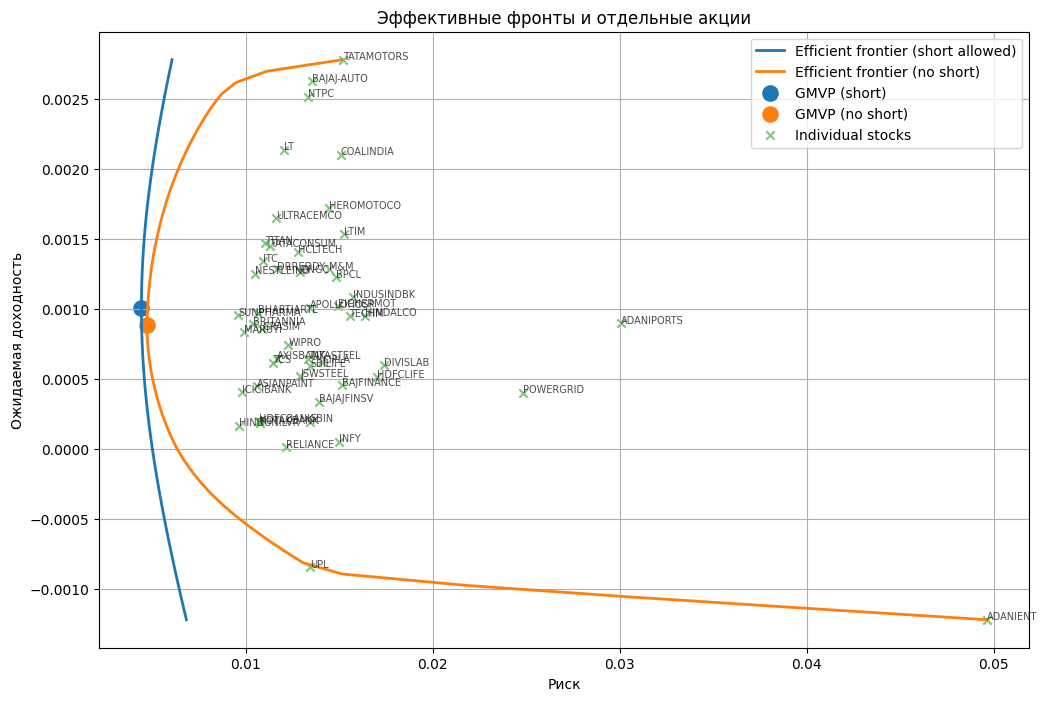

In [11]:
plt.figure(figsize=(12, 8))

# Эффективные фронты
plt.plot(risks_short, returns_short, label="Efficient frontier (short allowed)", linewidth=2)
plt.plot(risks_noshort, returns_noshort, label="Efficient frontier (no short)", linewidth=2)

# GMVP
plt.scatter(risk_gmvp_short, ret_gmvp_short, s=120, marker="o", label="GMVP (short)")
plt.scatter(risk_gmvp_noshort, ret_gmvp_noshort, s=120, marker="o", label="GMVP (no short)")

# Отдельные компании
plt.scatter(
    asset_stats["risk"],
    asset_stats["mean_return"],
    alpha=0.6,
    marker="x",
    label="Individual stocks"
)

# Подписи компаний
for _, row in asset_stats.iterrows():
    plt.text(
        row["risk"],
        row["mean_return"],
        row["Company"],
        fontsize=7, # Размер подписей
        alpha=0.7   # Видимость подписей
    )

plt.xlabel("Риск")
plt.ylabel("Ожидаемая доходность")
plt.title("Эффективные фронты и отдельные акции")
plt.legend()
plt.grid(True)
plt.show()

## Равновзвешенный портфель

In [12]:
# Портфель, в котором каждый актив получает одинаковую долю капитала
w_equal = np.ones(n) / n

risk_equal = np.sqrt(w_equal.T @ Sigma @ w_equal)
ret_equal = mu @ w_equal

In [13]:
def distance_to_frontier(risk, ret, frontier_risks, frontier_returns):
    """Calculate the Euclidean distance from a point to the efficient frontier."""
    return np.min(
        np.sqrt(
            (frontier_risks - risk) ** 2 +
            (frontier_returns - ret) ** 2
        )
    )

In [14]:
dist_equal_short = distance_to_frontier(
    risk_equal, ret_equal, risks_short, returns_short
)

dist_equal_noshort = distance_to_frontier(
    risk_equal, ret_equal, risks_noshort, returns_noshort
)

print("Расстояние equal-weight до фронта (short):", dist_equal_short)
print("Расстояние equal-weight до фронта (no short):", dist_equal_noshort)

Расстояние equal-weight до фронта (short): 0.001520717074911707
Расстояние equal-weight до фронта (no short): 0.0008711620320000957


## Вывод
Расстояние портфеля с равными долями вложения капитала до эффективного фронта без коротких позиций составляет 0.00087, что существенно меньше расстояния до фронта с разрешёнными короткими продажами (0.00152). Это говорит о том, что равновесный портфель находится очень близко к эффективному фронту без коротких позиций.
Поскольку портфель с равными весами не лежит непосредственно на эффективном фронте, он не является строго эффективным по Марковицу, однако его характеристики риска и доходности близки к оптимальным.

## Индексы рынка

Индекс Nifty 50 широко известен как эталон индийских фондовых рынков. Он отражает динамику 50 крупнейших компаний, акции которых котируются на Национальной фондовой бирже (NSE). Индекс NIFTY 50 — это индекс рыночной капитализации свободно обращающихся акций . Он рассчитывается на основе рыночной капитализации свободно обращающихся акций и является эффективным барометром рыночных тенденций, настроений инвесторов и отраслевых сдвигов.

Возьмём веса акций Nifty 50 в 2023 году в статье [Nifty 50 Weightage in 2025: Complete Guide to Stocks, Index, and Investment Strategies](https://ipocentral.in/nifty-50-stock-list-weightage/)

In [15]:
weights_dict = {
    'ADANIENT': 0.79,      # Adani Enterprises Ltd.
    'ADANIPORTS': 0.79,    # Adani Ports and Special Economic Zone Ltd.
    'APOLLOHOSP': 0.60,    # Apollo Hospitals Enterprise Ltd.
    'ASIANPAINT': 1.61,    # Asian Paints Ltd.
    'AXISBANK': 3.22,      # Axis Bank Ltd.
    'BAJAJ-AUTO': 0.81,    # Bajaj Auto Ltd.
    'BAJAJFINSV': 0.96,    # Bajaj Finserv Ltd.
    'BAJFINANCE': 2.15,    # Bajaj Finance Ltd.
    'BHARTIARTL': 2.75,    # Bharti Airtel Ltd.
    'BPCL': 0.45,          # Bharat Petroleum Corporation Ltd.
    'BRITANNIA': 0.66,     # Britannia Industries Ltd.
    'CIPLA': 0.69,         # Cipla Ltd.
    'COALINDIA': 0.90,     # Coal India Ltd.
    'DIVISLAB': 0.52,      # Divi’s Laboratories Ltd.
    'DRREDDY': 0.74,       # Dr. Reddy’s Laboratories Ltd.
    'EICHERMOT': 0.60,     # Eicher Motors Ltd.
    'GRASIM': 0.83,        # Grasim Industries Ltd.
    'HCLTECH': 1.63,       # HCL Technologies Ltd.
    'HDFCBANK': 13.52,     # HDFC Bank Ltd.
    'HDFCLIFE': 0.72,      # HDFC Life Insurance Company Ltd.
    'HEROMOTOCO': 0.57,    # Hero MotoCorp Ltd.
    'HINDALCO': 0.95,      # Hindalco Industries Ltd.
    'HINDUNILVR': 2.50,    # Hindustan Unilever Ltd.
    'ICICIBANK': 7.36,     # ICICI Bank Ltd.
    'INDUSINDBK': 1.11,    # IndusInd Bank Ltd.
    'INFY': 5.80,          # Infosys Ltd.
    'ITC': 4.31,           # ITC Ltd.
    'JSWSTEEL': 0.88,      # JSW Steel Ltd.
    'KOTAKBANK': 2.95,     # Kotak Mahindra Bank Ltd.
    'LT': 4.39,            # Larsen & Toubro Ltd.
    'LTIM': 0.61,          # LTIMindtree Ltd.
    'M&M': 1.63,           # Mahindra & Mahindra Ltd.
    'MARUTI': 1.43,        # Maruti Suzuki India Ltd.
    'NESTLEIND': 1.00,     # Nestle India Ltd.
    'NTPC': 1.56,          # NTPC Ltd.
    'ONGC': 0.84,          # Oil & Natural Gas Corporation Ltd.
    'POWERGRID': 1.14,     # Power Grid Corporation of India Ltd.
    'RELIANCE': 9.20,      # Reliance Industries Ltd.
    'SBILIFE': 0.68,       # SBI Life Insurance Company Ltd.
    'SBIN': 2.59,          # State Bank of India
    'SUNPHARMA': 1.43,     # Sun Pharmaceutical Industries Ltd.
    'TATACONSUM': 0.69,    # Tata Consumer Products Ltd.
    'TATAMOTORS': 1.45,    # Tata Motors Ltd.
    'TATASTEEL': 1.19,     # Tata Steel Ltd.
    'TCS': 4.05,           # Tata Consultancy Services Ltd.
    'TECHM': 0.84,         # Tech Mahindra Ltd.
    'TITAN': 1.61,         # Titan Company Ltd.
    'ULTRACEMCO': 1.28,    # UltraTech Cement Ltd.
    'UPL': 0.31,           # UPL Ltd.
    'WIPRO': 0.70          # Wipro Ltd.
}

weights = pd.Series(weights_dict)
weights = weights / weights.sum() # нормировка, чтобы сумма весов = 1

# Доходность индекса рынка
index_returns = returns[weights.index] @ weights

In [16]:
weights.sum()

np.float64(1.0)

### Распределение доходностей индекса

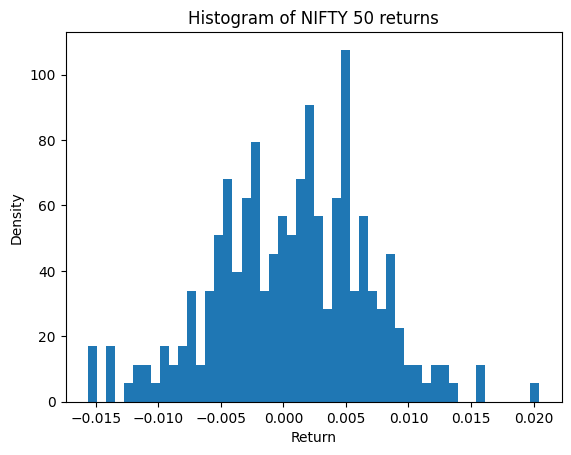

In [17]:
plt.hist(index_returns, bins=50, density=True)
plt.title("Histogram of NIFTY 50 returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.show()

### Вывод

Распределение доходностей индекса NIFTY 50 отличается от нормального распределения. Можно увидеть асимметрию и вытянутые хвосты, что указывает на наличие редких, но существенных экстремальных значений доходности. Подобные свойства типичны для финансовых временных рядов и свидетельствуют о наличии рыночного риска, не описываемого моделью нормального распределения.

### Собственные значения ковариационной матрицы

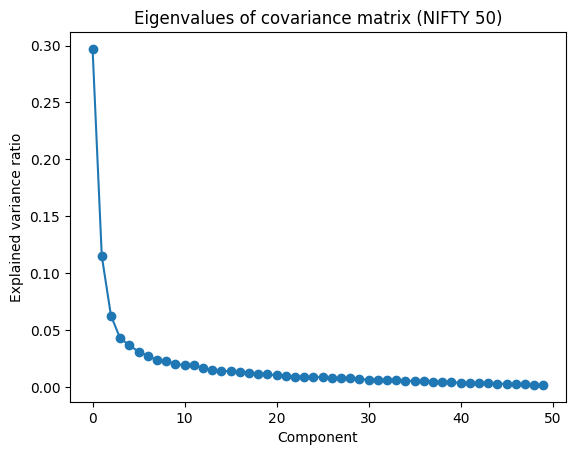

In [18]:
cov_matrix = returns.cov().loc[weights.index, weights.index]

eigenvalues, _ = np.linalg.eigh(cov_matrix)
eigenvalues = eigenvalues[::-1]

plt.plot(eigenvalues / eigenvalues.sum(), marker='o')
plt.title("Eigenvalues of covariance matrix (NIFTY 50)")
plt.ylabel("Explained variance ratio")
plt.xlabel("Component")
plt.show()

### Вывод

Среди собственных значений ковариационной матрицы доходностей акций индекса NIFTY 50 можно наблюдать одно доминирующее собственное значение, которое значительно превышает остальные по дисперсии. Это может указывать на наличие некоего сильного рыночного фактора, влияющего на динамику большинства акций.

### PCA-модель индекса рынка

Для построения альтернативного индекса рынка используется метод главных компонент (PCA), применённый к матрице доходностей выбранных активов.
Пусть

$
\begin{align}
R_t = (r_{1,t}, r_{2,t}, \dots, r_{N,t})^\top
\end{align}
$
— вектор доходностей $N$ активов в момент времени $t$.

Метод PCA ищет линейную комбинацию доходностей
$
\begin{align}
I_t = w^\top R_t
\end{align}
$
такую, что дисперсия $I_t$ максимальна при условии ($|w| = 1$).

Первая главная компонента решает задачу:
$
\begin{align}
\max_{w} ; \mathrm{Var}(w^\top R_t), \quad \text{при } |w|=1
\end{align}
$

Полученный временной ряд $I_t$ интерпретируется как **статистический рыночный фактор**, отражающий общее движение рынка.

Сравнение проводится с помощью коэффициента корреляции Пирсона:
$
\begin{align}
\rho = \mathrm{corr}(\tilde{I}_t, R^{\text{NIFTY}}_t)
\end{align}
$

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_returns = pca.fit_transform(returns[weights.index])

pca_index = pd.Series(
    pca_returns.flatten(),
    index=returns.index
)

# нормализуем
pca_index = pca_index / pca_index.std() * index_returns.std()

# Корреляция
corr = np.corrcoef(index_returns, pca_index)[0, 1]
print("Корреляция PCA-индекса с NIFTY 50:", corr)

Корреляция PCA-индекса с NIFTY 50: 0.6075879595506449


### Вывод

Индекс, построенный на основе первой главной компоненты, демонстрирует умеренную положительную корреляцию с реальным индексом NIFTY 50. Это говорит о том, что первая главная компонента отражает общий рыночный фактор, однако не полностью воспроизводит динамику индекса, веса которого определяются рыночной капитализацией компаний.

### Расстояние до фронта

In [20]:
# Ожидаемые доходности и ковариация
mu = returns.mean()
Sigma = returns.cov()

# Риск и доходность индекса
risk_index = np.sqrt(weights.T @ Sigma.loc[weights.index, weights.index] @ weights)
ret_index = mu.loc[weights.index] @ weights

In [21]:
dist_index_short = distance_to_frontier(
    risk_index,
    ret_index,
    risks_short,
    returns_short
)

dist_index_noshort = distance_to_frontier(
    risk_index,
    ret_index,
    risks_noshort,
    returns_noshort
)

print("Расстояние индекса до фронта (short):", dist_index_short)
print("Расстояние индекса до фронта (no short):", dist_index_noshort)

Расстояние индекса до фронта (short): 0.0012623300583953746
Расстояние индекса до фронта (no short): 0.0006314052742389853


### Вывод

Расстояние рыночного индекса NIFTY 50 до эффективного фронта без коротких позиций составляет 
0.00063, что существенно меньше расстояния до фронта с разрешёнными короткими продажами (0.00126). 
Это указывает на то, что индексный портфель находится близко к эффективному фронту в модели без коротких продаж.

В то же время индекс не лежит непосредственно на эффективном фронте, поэтому он не является строго эффективным по Марковицу.

# Задание 2

Для формирования "хорошего" портфеля был использован глобальный портфель минимального риска GMVP из задания 1, построенный на полном наборе из 50 акций. В выбор были включены 10 активов с наибольшими по модулю весами в GMVP, что показывает их наибольший вклад в минимизацию портфельного риска. Такой подход позволяет сохранить главные элементы ковариационной структуры рынка и обеспечивает максимально возможную диверсификацию при сокращении числа активов.

In [22]:
companies = returns.columns.to_numpy()   # имена компаний

gmvp_df = pd.DataFrame({
    "Company": companies,
    "weight": w_gmvp_short,
    "abs_weight": np.abs(w_gmvp_short)
})

top_companies = (
    gmvp_df
    .sort_values("abs_weight", ascending=False)
    .head(10)["Company"]
    .tolist()
)

print("10 активов с наибольшим вкладом в GMVP:")
print(top_companies)

10 активов с наибольшим вкладом в GMVP:
['SUNPHARMA', 'ICICIBANK', 'HDFCBANK', 'DRREDDY', 'ULTRACEMCO', 'MARUTI', 'ASIANPAINT', 'GRASIM', 'ONGC', 'TCS']


In [23]:
portfolio_df = df[df["Company"].isin(top_companies)]

returns_port = (
    portfolio_df
    .pivot(index="Date", columns="Company", values="log_return")
    .dropna()
)

mu_port = returns_port.mean().values
Sigma_port = returns_port.cov().values
n_port = len(mu_port)

## Сравнение эфффективных фронтов

In [24]:
# с короткими позициями
risks_short_port, returns_short_port, _ = efficient_frontier(
    mu_port, Sigma_port, n_points=10, short_allowed=True
)

# запрет на коротких позиций
risks_noshort_port, returns_noshort_port, _ = efficient_frontier(
    mu_port, Sigma_port, n_points=10, short_allowed=False
)

In [25]:
# Минимальный риск на каждом фронте
min_risk_short_port = risks_short_port.min()
min_risk_noshort_port = risks_noshort_port.min()

# Максимальная доходность при одинаковом уровне риска
common_risk_port = max(min_risk_short_port, min_risk_noshort_port)

# Находим доходности при общем уровне риска
idx_short_port = np.argmin(np.abs(risks_short_port - common_risk_port))
idx_noshort_port = np.argmin(np.abs(risks_noshort_port - common_risk_port))

ret_short_at_common_port = returns_short_port[idx_short_port]
ret_noshort_at_common_port = returns_noshort_port[idx_noshort_port]

# Сравнение эффективных фронтов
print("Исходный эффективный фронт для всех 50 активов")
print("="*50)
print("Минимальный риск (short allowed):", min_risk_short)
print("Минимальный риск (no short):", min_risk_noshort)
print("Доходность при общем уровне риска:")
print("  short allowed:", ret_short_at_common)
print("  no short     :", ret_noshort_at_common)
print("\n")

print("Эффективный фронт для наших 10 активов из портфеля")
print("="*50)
print("Минимальный риск (short allowed):", min_risk_short_port)
print("Минимальный риск (no short):", min_risk_noshort_port)
print("Доходность при общем уровне риска:")
print("  short allowed:", ret_short_at_common_port)
print("  no short     :", ret_noshort_at_common_port)

Исходный эффективный фронт для всех 50 активов
Минимальный риск (short allowed): 0.004424852589158784
Минимальный риск (no short): 0.004723575431603012
Доходность при общем уровне риска:
  short allowed: 0.0017180984763442585
  no short     : 0.0009020344863875606


Эффективный фронт для наших 10 активов из портфеля
Минимальный риск (short allowed): 0.005040425122869014
Минимальный риск (no short): 0.0050723785338775305
Доходность при общем уровне риска:
  short allowed: 0.0008408801770397453
  no short     : 0.0008408801770397453


## Вывод
Минимальный риск портфеля из 10 активов оказался выше, чем у портфеля из 50 активов, что показывает ослабление эффекта диверсификации при сокращении числа активов в портфеле. Для набора из 10 активов различия между эффективными фронтами с разрешёнными и запрещёнными короткими продажами в области минимального риска практически отсутствуют. Это указывает на то, что оптимальный портфель в данной точке эффективного фронта не использует короткие позиции, и соответствующее ограничение не является активным.

# Задание 3

Для построения личного оптимального портфеля использована классическая mean–variance [модель Марковица](https://www.hse.ru/data/2014/06/10/1324138096/Диплом%20Дорн.pdf), позволяющая учитывать компромисс между ожидаемой доходностью и риском. В качестве параметра неприятия риска выбран коэффициент γ = 10, что соответствует умеренно-консервативному отношению к риску.

In [26]:
gamma = 10  # параметр неприятия риска

# Преобразуем mu и Sigma в numpy массивы для работы с cvxpy
mu_array = mu.values
Sigma_array = Sigma.values
n = len(mu_array)

w = cp.Variable(n)
                
ret = mu_array @ w              
risk = cp.quad_form(w, Sigma_array)             

In [27]:
# Личный оптимальный портфель (short allowed)
problem = cp.Problem(
    cp.Maximize(ret - gamma * risk), # цель: макс. доходность минус штраф за риск
    [cp.sum(w) == 1]
)
problem.solve(solver=cp.ECOS)

w_personal_short = w.value

In [28]:
# Личный оптимальный портфель (no short)
problem = cp.Problem(
    cp.Maximize(ret - gamma * risk),
    [cp.sum(w) == 1, w >= 0]
)

problem.solve(solver=cp.ECOS)

w_personal_noshort = w.value

## Характеристика портфелей

In [29]:
def portfolio_stats(w, mu, Sigma):
    port_ret = mu @ w
    port_risk = np.sqrt(w.T @ Sigma @ w)
    return port_ret, port_risk


ret_short, risk_short = portfolio_stats(
    w_personal_short, mu_array, Sigma_array
)

ret_noshort, risk_noshort = portfolio_stats(
    w_personal_noshort, mu_array, Sigma_array
)

print("Личный портфель (short allowed)")
print("  Доходность:", ret_short)
print("  Риск:", risk_short)

print("\nЛичный портфель (no short)")
print("  Доходность:", ret_noshort)
print("  Риск:", risk_noshort)

Личный портфель (short allowed)
  Доходность: 0.010161408682497814
  Риск: 0.02184835973438725

Личный портфель (no short)
  Доходность: 0.002497440715149674
  Риск: 0.008482443126344687


### Вывод
Запрет коротких продаж снизил риск в 7.5 раз, но также снизил ожидаемую доходность в 5 раз.

## Доли портфеля

In [30]:
weights_short_df = pd.DataFrame({
    "Company": companies,
    "Weight": w_personal_short
}).sort_values("Weight", ascending=False)

weights_noshort_df = pd.DataFrame({
    "Company": companies,
    "Weight": w_personal_noshort
}).sort_values("Weight", ascending=False)

weights_short_df

,Company,Weight
34,NTPC,0.619033
26,ITC,0.558086
21,HINDALCO,0.518365
17,HCLTECH,0.515806
46,TITAN,0.493778
5,BAJAJ-AUTO,0.471175
29,LT,0.437783
42,TATAMOTORS,0.425970
41,TATACONSUM,0.395790
47,ULTRACEMCO,0.380551


In [31]:
weights_noshort_df

,Company,Weight
5,BAJAJ-AUTO,2.860634e-01
34,NTPC,2.580866e-01
42,TATAMOTORS,2.069865e-01
29,LT,1.881009e-01
12,COALINDIA,4.545674e-02
47,ULTRACEMCO,1.530596e-02
46,TITAN,3.489236e-10
41,TATACONSUM,3.098662e-10
26,ITC,2.668403e-10
30,LTIM,2.656608e-10


### Вывод
В случае, когда короткие продажи разрешены, оптимальный портфель включает множество активов с положительными и отрицательными весами, что обеспечивает более диверсифицированную структуру и балансирует риск и доходность.

Когда короткие продажи запрещены, оптимальный портфель становится концентрированным в нескольких активах с положительными весами, так как модель выбирает те акции, которые наилучшим образом минимизируют риск при данной доходности без возможности занимать короткие позиции.

## VaR и CVaR

In [32]:
def var_cvar(returns, alpha=0.95):
    VaR = -np.quantile(returns, 1 - alpha)
    CVaR = -returns[returns <= -VaR].mean()
    return VaR, CVaR

# Доходность портфелей 
portfolio_returns_short = returns.values @ w_personal_short
portfolio_returns_noshort = returns.values @ w_personal_noshort


VaR_short, CVaR_short = var_cvar(portfolio_returns_short)
VaR_noshort, CVaR_noshort = var_cvar(portfolio_returns_noshort)

print("VaR / CVaR (short allowed):", VaR_short, CVaR_short)
print("VaR / CVaR (no short):", VaR_noshort, CVaR_noshort)

VaR / CVaR (short allowed): 0.025450236430613875 0.03650599699076426
VaR / CVaR (no short): 0.010822007337999298 0.01600184036040168


## Вывод
Разрешение коротких продаж позволяет существенно увеличить ожидаемую доходность портфеля, однако сопровождается значительным ростом риска и хвостовых потерь (VaR и CVaR). Портфель без коротких позиций является более консервативным, характеризуется низкой волатильностью и меньшими потенциальными потерями, но при этом обеспечивает более скромную доходность.

# Задание 4
1. выбираем безрисковый актив, с доходностью 5%

In [33]:
r_f_annual = 0.05          # 5% годовых
r_f = r_f_annual / 252     # дневная безрисковая ставка

companies = returns_port.columns.tolist()

In [34]:
w = cp.Variable(n_port)

excess_ret = mu_port - r_f  # избыточная доходность в модели Марковица-Тобина
risk = cp.quad_form(w, Sigma_port)

2. Формируем рыночный портфель

С короткими продажами

In [35]:
problem = cp.Problem(
    cp.Maximize(excess_ret @ w),
    [
        risk <= 1
    ]
)

problem.solve(qcp=True)

# нормировка весов
w_market_short = w.value / np.sum(w.value)

# характеристики портфеля
ret_market_short = mu_port @ w_market_short
risk_market_short = np.sqrt(w_market_short.T @ Sigma_port @ w_market_short)

Без коротких продаж

In [36]:
problem = cp.Problem(
    cp.Maximize(excess_ret @ w),
    [
        risk <= 1,
        w >= 0
    ]
)

problem.solve(qcp=True)

# нормировка весов
w_market_noshort = w.value / np.sum(w.value)

# характеристики портфеля
ret_market_noshort = mu_port @ w_market_noshort
risk_market_noshort = np.sqrt(w_market_noshort.T @ Sigma_port @ w_market_noshort)

3. Смотрим доли активов в двух портфелях

In [37]:
weights_short_df = pd.DataFrame({
    "Company": companies,
    "Weight": w_market_short
}).sort_values("Weight", ascending=False)

weights_noshort_df = pd.DataFrame({
    "Company": companies,
    "Weight": w_market_noshort
}).sort_values("Weight", ascending=False)

In [38]:
weights_short_df

,Company,Weight
9,ULTRACEMCO,0.474870
6,ONGC,0.265800
1,DRREDDY,0.246902
7,SUNPHARMA,0.224921
5,MARUTI,0.107225
0,ASIANPAINT,0.065194
8,TCS,-0.016698
4,ICICIBANK,-0.025150
3,HDFCBANK,-0.135493
2,GRASIM,-0.207571


In [39]:
weights_noshort_df

,Company,Weight
9,ULTRACEMCO,3.265476e-01
1,DRREDDY,2.016941e-01
6,ONGC,1.969856e-01
7,SUNPHARMA,1.750064e-01
5,MARUTI,8.365891e-02
0,ASIANPAINT,1.610739e-02
8,TCS,2.593037e-08
4,ICICIBANK,1.457130e-08
2,GRASIM,9.272054e-09
3,HDFCBANK,8.342014e-09


В случае разрешённых коротких продаж оптимальный рыночный портфель содержит как положительные, так и отрицательные веса. Отрицательные веса соответствуют коротким позициям, используемым для хеджирования риска и увеличения ожидаемой доходности за счёт использования кредитного плеча. 

В случае с запретом коротких продаж, модель распределила капитал между несколькими активами — `ULTRACEMCO`, `DRREDDY`, `ONGC`, `SUNPHARMA`, `MARUTI` и `ASIANPAINT` - с основной частью капитала в ULTRACEMCO. Остальные активы получили очень малые или практически нулевые веса, что отражает ограничение на короткие позиции и стремление модели минимизировать риск при сохранении доходности.

4. VaR и CVaR
Для подсчёта используем функцию из предыдущего задания

In [40]:
# Доходность портфелей 
portfolio_returns_short = returns_port.values @ w_market_short
portfolio_returns_noshort = returns_port.values @ w_market_noshort


VaR_short, CVaR_short = var_cvar(portfolio_returns_short)
VaR_noshort, CVaR_noshort = var_cvar(portfolio_returns_noshort)

In [41]:
print("Markowitz–Tobin model (10 assets)")
print("="*50)

print("Market portfolio (short allowed):")
print("Return:", ret_market_short)
print("Risk:", risk_market_short)
print("VaR / CVaR:", VaR_short, CVaR_short)

print("\nMarket portfolio (no short):")
print("Return:", ret_market_noshort)
print("Risk:", risk_market_noshort)
print("VaR / CVaR:", VaR_noshort, CVaR_noshort)

Markowitz–Tobin model (10 assets)
Market portfolio (short allowed):
Return: 0.0015422961515635116
Risk: 0.007153283564681944
VaR / CVaR: 0.009933041380089465 0.013073669079376906

Market portfolio (no short):
Return: 0.0012886618754010504
Risk: 0.006218422012090511
VaR / CVaR: 0.009172855167823485 0.011520808019123703


## Вывод
Разрешение коротких продаж повышает ожидаемую доходность портфеля (0.154% против 0.129% в день) при умеренном росте риска: он увеличивается на 15%, VaR и CVaR — на 8–13%. Потери остаются низкими и приемлемыми даже для консервативных инвесторов. Запрет шортов даёт более консервативный портфель с положительными весами, немного меньшей доходностью и риском, сохраняя диверсификацию и концентрацию в наиболее привлекательных активах.

# Задание 5

**Математическая модель:**

$
\begin{align}
r_i = \alpha_i + \beta_i r_m + \epsilon_i, \quad i = 1, \dots, 10
\end{align}
$

В матричном формате:
$
\begin{align}
y_i​=Xθ_i​+ε_i​,
\end{align}
$

$
\begin{align}
\mathrm{Var}(\epsilon_i) = \sigma_{\epsilon_i}^2, \quad
\end{align}
$

**Оптимальные веса рыночного портфеля:**

$
\begin{align}
w_i = \frac{\beta_i / \sigma_{\epsilon_i}^2}{\sum_{j=1}^{10} \beta_j / \sigma_{\epsilon_j}^2}
\end{align}
$

In [42]:
# One-factor model: r_i = alpha_i + beta_i * r_m + epsilon_i

# Доходности 10 активов и рыночного индекса
returns_10 = returns_port.copy()
market_returns = index_returns.loc[returns_10.index]

# Регрессия каждого актива на рыночный индекс
alphas = []
betas = []
residual_vars = []

# Проверка условий модели с одним фактором
for company in returns_10.columns:
    # Добавляем константу для регрессии
    X = np.column_stack([np.ones(len(market_returns)), market_returns])
    y = returns_10[company].values
    
    # OLS регрессия (решение задачи через МНК)
    coeffs = np.linalg.lstsq(X, y, rcond=None)[0]
    alpha, beta = coeffs[0], coeffs[1]
    
    # Остатки и их дисперсия
    predictions = X @ coeffs        # r^_i,t
    residuals = y - predictions     # ε_i,t
    residual_var = np.var(residuals)
    
    alphas.append(alpha)
    betas.append(beta)
    residual_vars.append(residual_var)

alphas = np.array(alphas)
betas = np.array(betas)
residual_vars = np.array(residual_vars)

# Параметры рыночного фактора
market_mean = market_returns.mean()
market_var = market_returns.var()

# Матрица ковариации в однофакторной модели
# Sigma = beta * beta^T * sigma_m^2 + diag(sigma_eps^2)
Sigma_1f = np.outer(betas, betas) * market_var + np.diag(residual_vars)

# Ожидаемые доходности в модели
mu_1f = alphas + betas * market_mean

print("One-Factor Model Results (10 assets)")
print("="*50)
print("\nAlphas:", alphas)
print("\nBetas:", betas)
print("\nResidual variances:", residual_vars)
print("\nMarket factor stats:")
print(f"  Mean: {market_mean}")
print(f"  Variance: {market_var}")

One-Factor Model Results (10 assets)

Alphas: [ 6.24435640e-05  9.71776087e-04  1.57631556e-04 -6.16641976e-04
 -2.81141253e-04  4.59620649e-04  7.49697637e-04  6.42862172e-04
 -7.37442784e-05  1.11666530e-03]

Betas: [0.54856459 0.43920544 0.98732114 1.15181132 0.97134624 0.52659511
 0.72770236 0.44014658 0.97736891 0.74887475]

Residual variances: [1.00279676e-04 1.28072270e-04 8.13424595e-05 6.45842873e-05
 5.99809597e-05 8.73100589e-05 1.46030820e-04 8.43865817e-05
 9.45146054e-05 1.13326017e-04]

Market factor stats:
  Mean: 0.0007064288068742673
  Variance: 3.7649090605311704e-05


* Большинство акций имеют положительные бета-коэффициенты (0.44–1.15), что указывает на умеренную или сильную зависимость их доходностей от рыночного индекса.
* Альфы малы и близки к нулю, что соответствует [гипотезе отсутствия систематической избыточной доходности](https://www.tbank.ru/invest/social/profile/nurvadi_96/d0def5a4-a967-430d-a1b7-d5f4431b25d4/?author=profile).
* Остаточная дисперсия (разность между наблюдаемыми значениями и значениями, предсказанными моделью) относительно небольшая (≈0.00006–0.00015), большая часть риска объясняется рыночным фактором.
* Средняя доходность рыночного фактора ≈0.07% в день, а его дисперсия ≈0.0038%, что задаёт масштаб систематического риска для портфеля.

### Расчёт рыночного портфеля по формуле однофакторной модели

In [43]:
# 1. Ненормированные веса рыночного портфеля
w_1f_raw = betas / residual_vars

# 2. Нормировка весов (сумма весов = 1)
w_1f = w_1f_raw / w_1f_raw.sum()

# 3. Доходность и риск портфеля в one-factor модели
# Используем полную ковариационную матрицу Sigma_1f
ret_1f = mu_1f @ w_1f
risk_1f = np.sqrt(w_1f.T @ Sigma_1f @ w_1f)

print("\nOne-Factor Market Portfolio")
print("=" * 50)
print("Weights:", w_1f)
print("Expected return:", ret_1f)
print("Risk (std):", risk_1f)


One-Factor Market Portfolio
Weights: [0.06199012 0.03886156 0.13754626 0.20209805 0.18351362 0.06834712
 0.05646988 0.059106   0.11718371 0.07488368]
Expected return: 0.0006895639961200135
Risk (std): 0.006203229973915984


### Сравнение с портфелем из пункта 4

1. Доходность

* **One-Factor Market Portfolio:** 0.00069 (≈0.069% в день)
* **Markowitz–Tobin (short allowed):** 0.00154 (≈0.154% в день)
* **Markowitz–Tobin (no short):** 0.00129 (≈0.129% в день)

**Вывод:** портфель Марковица–Тобина обеспечивает более высокую ожидаемую доходность, особенно при разрешении коротких продаж. Однофакторная модель ориентирована на рыночную структуру и даёт умеренную доходность, отражающую влияние рынка.

---

2. Риск
* **One-Factor Market Portfolio:** 0.0062 (≈0.62% в день)
* **Markowitz–Tobin (short allowed):** 0.00715 (≈0.72% в день)
* **Markowitz–Tobin (no short):** 0.00622 (≈0.62% в день)

**Вывод:** риск однофакторного портфеля близок к портфелю Марковица–Тобина без коротких продаж. Разрешение шортов увеличивает риск, но и доходность растёт лучше.

---

3. Весовые доли активов

* **One-Factor модель:** концентрация в активах с высокой бетой (0.14–0.20)
* **Markowitz–Tobin:** при разрешении шортов портфель может содержать отрицательные доли; без шортов — только положительные, распределение более «консервативное».

**Вывод:** однофакторная модель акцентирует внимание на систематическом риске (β), тогда как Марковица–Тобин учитывает как риск, так и доходность каждого актива, позволяя более точно оптимизировать портфель с учётом ограничений на короткие продажи.